# LAB: (quasi-) Newton methods

Author : Alexandre Gramfort

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
and compare your implementation with the BFGS and L-BFGS solvers in scipy

You will need to knowledge on **line search methods** and **conjugate gradient** in particular you should reuse the notebooks presented during the lectures.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 30th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 24 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "Xingyuan"
ln1 = "XUE"
fn2 = "Ling"
ln2 = "JIN"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_xue_xingyuan_and_jin_ling.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.linalg as linalg
import scipy.sparse as sparse

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [4]:
from optim_utils import test_solver

You'll have work only with the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

Let us now make an example with a gradient descent.

In [5]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now I can call the `test_solver` function with this solver:


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0522931, l_inf_norm(grad): 0.162853
iter: 3, f: 0.020076, l_inf_norm(grad): 0.110187
iter: 4, f: 0.00874399, l_inf_norm(grad): 0.0745522
iter: 5, f: 0.00395127, l_inf_norm(grad): 0.050442
iter: 6, f: 0.00180287, l_inf_norm(grad): 0.0341291
iter: 7, f: 0.000824643, l_inf_norm(grad): 0.0230917
iter: 8, f: 0.000377432, l_inf_norm(grad): 0.0156239
iter: 9, f: 0.000172774, l_inf_norm(grad): 0.0105711
iter: 10, f: 7.90929e-05, l_inf_norm(grad): 0.00715241
iter: 11, f: 3.62076e-05, l_inf_norm(grad): 0.00483932
iter: 12, f: 1.65754e-05, l_inf_norm(grad): 0.00327429
iter: 13, f: 7.588e-06, l_inf_norm(grad): 0.00221538
iter: 14, f: 3.47369e-06, l_inf_norm(grad): 0.00149893
iter: 15, f: 1.59021e-06, l_inf_norm(grad): 0.00101417
iter: 16, f: 7.2798e-07, l_inf_norm(grad): 0.00068619
iter: 17, f: 3.3326e-07, l_inf_norm(grad): 0.000464276
iter: 18, f: 1.52562e-07, l_inf_norm(grad): 0.000314129
iter: 19, f: 6.98411

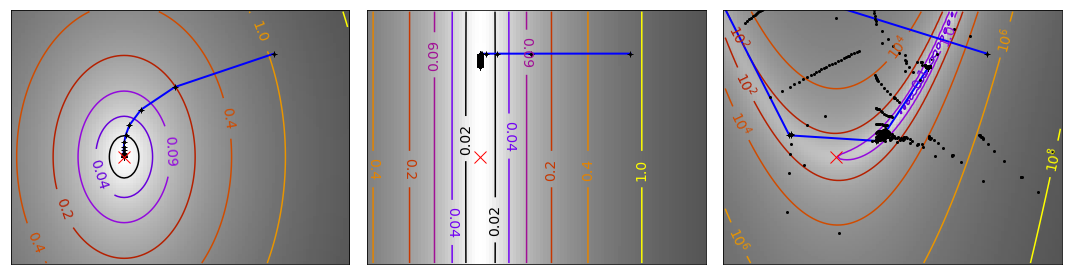

In [6]:
test_solver(gradient_descent)

# Part 2: Implement Newton method

You now need to implement Newton method using either `linalg.solve` or `sparse.linalg.cg` solve the linear system at each iteration. You need to implement both versions.

You're expected to comment in a few lines what you see.

In [7]:
def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        hessian_x = f_hessian(x)
        ####################################
        # Compute here the search direction
        # Two functions to solve linear system here
        #d = linalg.solve(hessian_x, - grad_x)  # dk = -B_kg_k
        d, _ = sparse.linalg.cg(hessian_x, - grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        x += step * d
        ##################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 2
iter: 1, f: 3.40668e-26, l_inf_norm(grad): 2.12057e-13

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 0.137976, l_inf_norm(grad): 3.9843
iter: 4, f: 0.088137, l_inf_norm(grad): 6.14586
iter: 5, f: 0.0414804, l_inf_norm(grad): 3.93321
iter: 6, f: 0.0162138, l_inf_norm(grad): 2.7976
iter: 7, f: 0.00446914, l_inf_norm(grad): 1.29953
iter: 8, f: 0.000705202, l_inf_norm(grad): 0.668389
iter: 9, f: 3.34966e-05, l_inf_norm(grad): 0.121298
iter: 10, f: 1.24866e-07, l_inf_norm(grad): 0.00982241
iter: 11, f: 2.01025e-12, l_inf_norm(grad): 3.05844e-05
iter: 12, f: 5.2958e-22, l_inf_norm(grad): 6.41073e-10


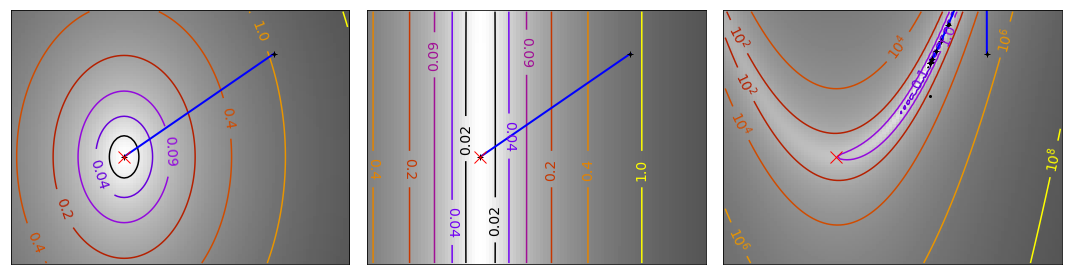

In [8]:
# The result of using `linalg.solve`
test_solver(newton)


Running solver on case 1
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 2
iter: 1, f: 3.40668e-26, l_inf_norm(grad): 2.12057e-13

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 0.137976, l_inf_norm(grad): 3.9843
iter: 4, f: 0.088137, l_inf_norm(grad): 6.14586
iter: 5, f: 0.0414804, l_inf_norm(grad): 3.93321
iter: 6, f: 0.0162138, l_inf_norm(grad): 2.7976
iter: 7, f: 0.00446914, l_inf_norm(grad): 1.29953
iter: 8, f: 0.000705202, l_inf_norm(grad): 0.668389
iter: 9, f: 3.34966e-05, l_inf_norm(grad): 0.121298
iter: 10, f: 1.24866e-07, l_inf_norm(grad): 0.00982241
iter: 11, f: 2.01025e-12, l_inf_norm(grad): 3.05844e-05
iter: 12, f: 5.2958e-22, l_inf_norm(grad): 6.41073e-10


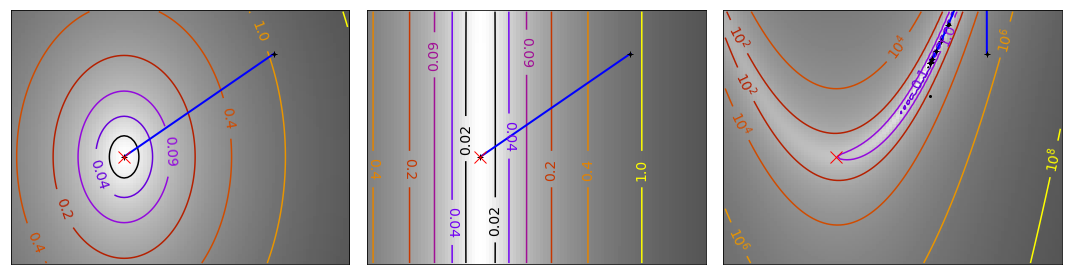

In [9]:
# The result of using `sparse.linalg.cg`
test_solver(newton)

#### Your comments here

- We can observe that for the ill-conditioned and well-conditioned cases with quadratic function, the Newton method can find the solution in one iteration. It is faster than the gradient method in well-conditioned case and can find the minimum in ill-conditioned case while this is not the case for the gradient descent method. Thus, the Newton method is not affected by the bad condition.

- In the third case, we can observe that the minimum of the function is hard to search as the direction changes much and that the function is not convex. In this super ill-conditioned and non-convex case, the gradient method can not converge within 100 iterations while the Newton method converges within 12 iterations and finds the global minimum 0.

- Comparing the two methods `linalg.solve` and `sparse.linalg.cg`, Specifically in the case 2, under the `linalg.solve` method, it converges to minimum 0 within 1 iteration. While in the same case, the `sparse.linalg.cg` method cannot reach minimum 0. Thus we may lose some precision when using the `sparse.linalg.cg` method.

# Part 2: Implement DFP algorithm

You now need to implement the DFP algorithm.

In [10]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k=list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        d = - np.dot(B, grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        s = step * d
        x += s
        y = f_grad(x) - grad_x
        grad_x = new_grad
        ##################################
        
        #########################################################
        # Update the inverse Hessian approximation
        By = np.dot(B, y)
        B += np.outer(s, s) / np.dot(s, y) - np.outer(By, By) / y.dot(By)
        #########################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0214911, l_inf_norm(grad): 0.114753
iter: 3, f: 0.00899657, l_inf_norm(grad): 0.069501
iter: 4, f: 0.00023476, l_inf_norm(grad): 0.0175216
iter: 5, f: 1.76801e-05, l_inf_norm(grad): 0.00465113
iter: 6, f: 3.20353e-08, l_inf_norm(grad): 0.000140183
iter: 7, f: 1.32183e-10, l_inf_norm(grad): 8.99094e-06
iter: 8, f: 8.82459e-15, l_inf_norm(grad): 1.04309e-07

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000138677, l_inf_norm(grad): 0.000270594
iter: 4, f: 1.92681e-07, l_inf_norm(grad): 0.000503909
iter: 5, f: 1.4273e-07, l_inf_norm(grad): 0.000433799
iter: 6, f: 3.512e-14, l_inf_norm(grad): 1.6706e-08

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.56575, l_inf_norm(grad): 24.138
iter: 3, f: 7.34339, l_inf_norm(grad): 4.87789
iter: 4, f: 7.29892, l_inf_norm(grad): 8.4

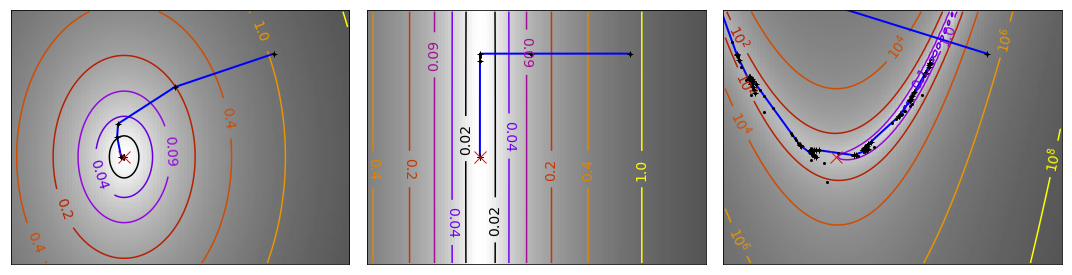

In [11]:
test_solver(dfp)

#### Your comments here

- The DFP method converges more slowly than the Newton method but still faster than the gradient method in the convex case. The DFP method can converge in 6 iterations in the ill-conditioned case. Thus it is also not sensitive to bad condition. In the ill-conditioned case, it can have orthogonal diretions.

- In the non-convex and super ill-conditioned case, the DFP method can find the minimum but it takes more iterations to find the minimum than the Newton method. Thus, it is more affected by the non-convexity of the objective and bad condition than the Newton method.

# Part 3: Implement BFGS algorithm

You now need to implement the BFGS algorithm.

In [12]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    H = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        d = linalg.solve(H, - grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        s = step * d
        x += s
        y = f_grad(x) - grad_x
        grad_x = new_grad
        ##################################
        
        #####################################################
        # Update the Hessian approximation   
        H += np.outer(y, y) / np.dot(y, s) - np.dot(np.dot(H, np.outer(s, s)), H) / np.dot(s, np.dot(H, s))
        #####################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0209281, l_inf_norm(grad): 0.11324
iter: 3, f: 0.00806831, l_inf_norm(grad): 0.0656686
iter: 4, f: 3.9809e-05, l_inf_norm(grad): 0.00723054
iter: 5, f: 4.69973e-07, l_inf_norm(grad): 0.000735419
iter: 6, f: 7.22702e-11, l_inf_norm(grad): 6.78586e-06
iter: 7, f: 2.47614e-14, l_inf_norm(grad): 1.18656e-07

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000119306, l_inf_norm(grad): 0.00025098
iter: 4, f: 6.91982e-13, l_inf_norm(grad): 9.54949e-07

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.59071, l_inf_norm(grad): 26.034
iter: 3, f: 7.34411, l_inf_norm(grad): 4.87129
iter: 4, f: 7.29555, l_inf_norm(grad): 8.30631
iter: 5, f: 6.98403, l_inf_norm(grad): 49.3631
iter: 6, f: 6.72314, l_inf_norm(grad): 26.9831
iter: 7, f: 6.31556, l_inf_norm(grad): 14.5499
iter: 8, f: 5.

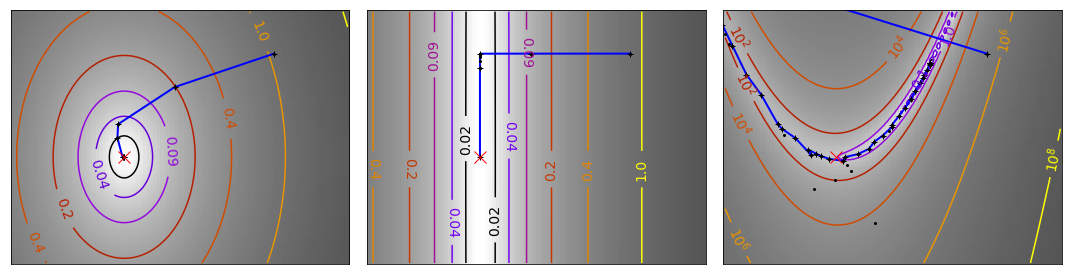

In [13]:
test_solver(bfgs)

#### Your comments here

- In the convex and non-convex cases, the BGGS method performs like the DFP method. 
- In the non-convex and super ill-conditioned case, it converges to the global minimum faster than the DFP method and takes better step size. While in the DFP method, the step size is too small.

# Part 4: Do the same now with scipy implementation of BFGS and L-BFGS


Running solver on case 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7

Running solver on case 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10

Running solver on case 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 35
         Gradient evaluations: 35


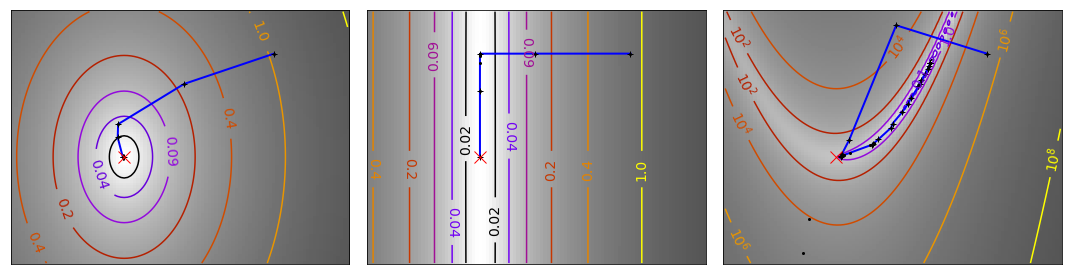

In [20]:
from scipy.optimize import fmin_bfgs, fmin_l_bfgs_b

# BFGS
def sci_bfgs(x0, f, f_grad, f_hessian):
    all_x_k, all_f_k = list(), list()
    def get_f_k(x):
        all_f_k.append(f(x))
        
    _, all_x_k = fmin_bfgs(f=f, x0=x0, fprime=f_grad, 
                           maxiter=100, retall=True)
    return np.array(all_x_k), np.array(all_f_k)
    
test_solver(sci_bfgs)


Running solver on case 1
total iter: 5, l_inf_norm(grad): 1.87239e-06

Running solver on case 2
total iter: 4, l_inf_norm(grad): 5.48395e-07

Running solver on case 3
total iter: 19, l_inf_norm(grad): 1.41856e-08


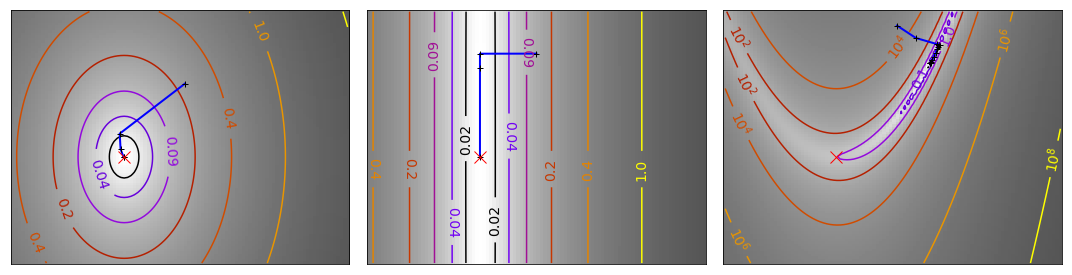

In [24]:
# L-BFGS
# we define the global variable for all x_k and the callback
# function to retrieve all x_k
def sci_l_bfgs(x0, f, f_grad, f_hessian):
    all_x_k, all_f_k = list(), list()
    def get_x_k_f_k(x):
        all_x_k.append(x.copy())
        all_f_k.append(f(x))
        
    _, _, info_dict = fmin_l_bfgs_b(func=f, x0=x0, fprime=f_grad, 
                  maxiter=100, callback=get_x_k_f_k, iprint=0)
    print('total iter: %d, l_inf_norm(grad): %.6g' %
          (info_dict['nit'], np.max(np.abs(info_dict['grad']))))
    return np.array(all_x_k), np.array(all_f_k)
    
test_solver(sci_l_bfgs)

#### Your comments here

- In the convex cases the method that we write and the BFGS method of scipy have nearly the same performance. The BFGS method of scipy is slightly better than our hand-written method in the well-conditioned case taking one iteration less to converge to the minimum. The L-BFGS method is even faster than the BFGS method in scipy in the well-conditioned case.

- In the non-convex and super ill-conditioned case, the method of BFGS and L-BFGS in scipy converge faster than our hand-written method. 

- In the non-convex and super ill-conditioned case, the method of L-BFGS is even faster than the BFGS method in scipy.

- We conclude that the BFGS and L-BFGS algorithms in scipy are less affected by the non-convexity of the objective and bad condition than our hand-written algorithm. 